In [6]:
%matplotlib inline
import read_mist_models
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import glob
from scipy.stats import kde, norm
import scipy as scipy
from scipy import spatial
from scipy.optimize import curve_fit

import math

from isochrones.mist import MISTIsochroneGrid

problem: [WinError 126] The specified module could not be found


SystemExit: 1

In [7]:
#Read in all files
filenames = glob.glob('MIST_v1.2_vvcrit0.0_HST_ACSWF/MIST*.cmd')
filenames = filenames[0:2]

In [8]:
#Initialize arrays to store info we care about (should add other filters as well)
ages = np.arange(5.,10.3,0.05)
F475W = np.array([])
F814W = np.array([])
bolLum = np.array([])
tEff = np.array([])
mass = np.array([])

In [9]:
#Combine data from all files into single arrays
for filename in filenames:
    isocmd = read_mist_models.ISOCMD(filename)
    #loop through ages
    for age in ages:
        age_ind = isocmd.age_index(age)
        F475W = np.concatenate((F475W,isocmd.isocmds[age_ind]['ACS_WFC_F475W']),axis=0)
        F814W = np.concatenate((F814W,isocmd.isocmds[age_ind]['ACS_WFC_F814W']),axis=0)
        bolLum = np.concatenate((bolLum,isocmd.isocmds[age_ind]['log_L']),axis=0)
        tEff = np.concatenate((tEff,isocmd.isocmds[age_ind]['log_Teff']),axis=0)
        mass = np.concatenate((mass,isocmd.isocmds[age_ind]['star_mass']),axis=0)

Reading in: MIST_v1.2_vvcrit0.0_HST_ACSWF\MIST_v1.2_feh_m0.25_afe_p0.0_vvcrit0.0_HST_ACSWF.iso.cmd
Reading in: MIST_v1.2_vvcrit0.0_HST_ACSWF\MIST_v1.2_feh_m0.50_afe_p0.0_vvcrit0.0_HST_ACSWF.iso.cmd


In [10]:
#Convert from absolute magnitude to vegamag
dist = 770 * 10**3 #Dist to m31 in pc. Assume this is the distance to every star
F475WVega = F475W + 5*math.log10(dist/10)
F814WVega = F814W + 5*math.log10(dist/10)

In [11]:
#Load the PHAT Data (saved from Stellar Population notebook)
F475W_GST = np.load('F475W_GST_data_b03.npy')
F814W_GST = np.load('F814W_GST_data_b03.npy')

In [12]:
def kroupa(marr):
    resArr = []
    for m in marr:
        if m <= 0.08:
            resArr.append(13*m**(-0.3))
        elif m > 0.08 and m < 0.5:
            resArr.append(m**(-1.3))
        else:
            resArr.append(.5*m**(-2.3))
    return resArr

def chabrier(marr):
    resArr = []
    for m in marr:
        if m < 1:
            resArr.append(0.158*(1/(np.log(10)*m))*np.exp(-np.log10(m)-np.log10(0.08)**2 /(2*.69**2)))
        else:
            resArr.append(0.02*m**(-2.3))
    return resArr

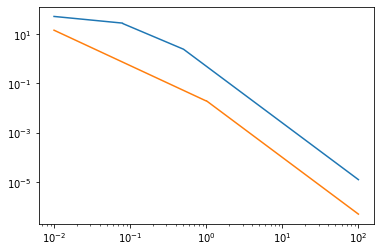

In [13]:
#USE Chabrier Inital Mass Function
m = np.logspace(-2,2,1000)
#plt.plot(m,kroupa(m))
plt.plot(m,kroupa(m))
plt.plot(m,chabrier(m))
plt.xscale('log')
plt.yscale('log')
plt.show()

In [14]:
nearestRadii = np.array([1,2,3])
nearestMass = np.array([1,2,3])
print(np.mean(nearestRadii))
print(sum(((chabrier(nearestMass) / sum(chabrier(nearestMass))) *nearestRadii)))

2.0
1.2828503679211187


### Here's what the MIST Isochrones look like!

In [15]:
#Make a HR density plot
#x = tEff
#y = bolLum

In [16]:
#nbins=300
#k = kde.gaussian_kde([x,y])
#xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
#zi = k(np.vstack([xi.flatten(), yi.flatten()]))

In [17]:
#plt.figure(figsize=(8,6))
#plt.pcolormesh(xi, yi, zi.reshape(xi.shape))
#plt.colorbar()    
#plt.xlabel('log10(TEff)')
#plt.ylabel('log10(Lum)')
#plt.title('MIST HR')
#plt.axis([3.45,4.8,0,6])
#plt.gca().invert_xaxis()
#plt.show()

In [18]:
#Make a density plot of the color index
#x = np.subtract(F475W,F814W)
#y = F814W

In [19]:
#nbins=300
#k = kde.gaussian_kde([x,y])
#xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
#zi = k(np.vstack([xi.flatten(), yi.flatten()]))

In [20]:
#plt.figure(figsize=(8,6))
#plt.pcolormesh(xi, yi, zi.reshape(xi.shape))
#plt.colorbar()    
#plt.xlabel('F475W-F814W')
#plt.ylabel('F814W')
#plt.gca().invert_yaxis()
#plt.show()

## Now we can find the closest MIST stars to each PHAT star and compare their properties

In [21]:
#Define function to find closest points in isochrone
def do_kdtree(combined_x_y_arrays,points,numNeighbors=1):
    mytree = scipy.spatial.cKDTree(combined_x_y_arrays)
    dist, indexes = mytree.query(points,k=numNeighbors)
    return indexes

def sourceRadius(bolLum,tEff):
    return math.sqrt(((10**bolLum)*3.85*10**26) /(4*math.pi*5.670367*10**(-8)*(10**tEff)**4))/(6.9551*10**8)
    
def sourceRadiiArr(bolLumArr,tEffArr):
    return [sourceRadius(bolLumArr[i], tEffArr[i]) for i in range(len(bolLumArr))]


In [22]:
F475WminusF814_GST = np.subtract(F475W_GST,F814W_GST)
PHATData = [[F475WminusF814_GST[i], F814W_GST[i]] for i in range(len(F814W_GST))]

In [23]:
x = np.subtract(F475WVega,F814WVega)
y = F814WVega
combined_xy_array = np.dstack([x,y])[0]
#testpoints = np.array([[0.25099945,24.153]]) #This will be PHAT data
sourceRadii = np.array([])
numNeighbors = 10; #Number of closest points to return

resultIdx = do_kdtree(combined_xy_array,PHATData,numNeighbors) #Find closest numNeighbors neighbors

neighborRadii = [sourceRadiiArr(bolLum[i], tEff[i]) for i in resultIdx] #Calculate the source radius for each neighbor
neighborMass = [mass[i] for i in resultIdx]



# print('target points: ', testpoints)
# print('closest points: ', x[resultIdx], y[resultIdx])
# print('resultIdx: ', resultIdx)
# print('T_Eff: ', tEff[resultIdx])
# print('bol_Lum: ',bolLum[resultIdx])
# print('source radii: ', sourceRadii)

## Weighting the MIST data using IMF

In [24]:
weightedRadii = [sum(((chabrier(neighborMass[i]) / sum(chabrier(neighborMass[i]))) *neighborRadii[i])) for i in range(len(neighborMass))]

In [25]:
#Calculate the average and std of the nearest neighbors
meanSourceRadii = [np.mean(neighborRadii[i]) for i in range(len(neighborRadii))] #This is the best guess for the PHAT Star's radius
stdSourceRadii = [np.std(neighborRadii[i]) for i in range(len(neighborRadii))] 

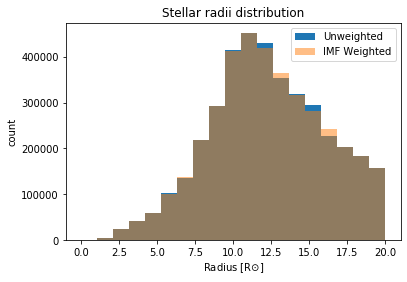

In [26]:
meanPlot = plt.hist(meanSourceRadii,bins=np.linspace(0,20,20), label='Unweighted')
weightedPlot = plt.hist(weightedRadii, bins=np.linspace(0,20,20),label='IMF Weighted',alpha=0.5)
plt.title('Stellar radii distribution')
plt.xlabel('Radius [R$\odot$]')
plt.ylabel('count')
plt.legend()
plt.savefig('WeightedVsUnweightedDistribution.png')
plt.show()

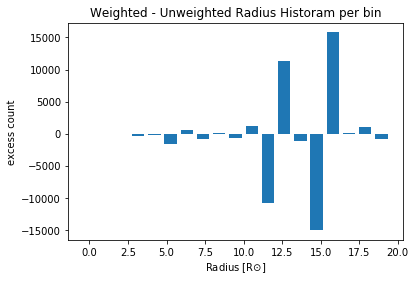

In [27]:
#Mass and radius don't correlate 1 to 1 so that's what disfavoring high mass doesn't necessarily disfavor high radius
plt.bar(weightedPlot[1][0:-1], height=(weightedPlot[0] - meanPlot[0]))
plt.title('Weighted - Unweighted Radius Historam per bin')
plt.xlabel('Radius [R$\odot$]')
plt.ylabel('excess count')
plt.savefig('WeightedVsUnweightedCount')
plt.show()

## Distance Weighting

We also want weight our results by how good our fit is. One way to do this is to calculate the distance
to the synthetic stars implied by the photometry. If this distance is similar to the distance to M31 (the PHAT stars),
then this is a nice verification that the fit is good.

In [28]:
F475WNeighbors = F475W[resultIdx]
avgF475WNeighbors = [np.mean(F475WNeighbors[i]) for i in range(len(F475WNeighbors))]
F475W_GST_All = [F475W_GST for i in range(numNeighbors)]
F475W_GST_All = np.transpose(F475W_GST_All)

In [29]:
distModulusF475W = np.subtract(F475W_GST_All,F475WNeighbors)
distAbs = [(10 * 10**(distModulusF475W[i] *.2))/1000 for i in range(len(distModulusF475W))] #Result in kpc
distWeights = abs(1/(distAbs - 770*np.ones(np.shape(distAbs)))) / sum(abs(1/(distAbs - 770*np.ones(np.shape(distAbs[1])))))
weightedRadii2 = [sum(distWeights[i]*neighborRadii[i]/sum(distWeights[i])) for i in range(len(distWeights))]

In [30]:
weightedRadiiFinal = [(weightedRadii[i] + weightedRadii2[i]) /2. for i in range(len(weightedRadii))] 

In [31]:
distAbsMean = [np.mean(distAbs[i]) for i in range(len(distAbs))]

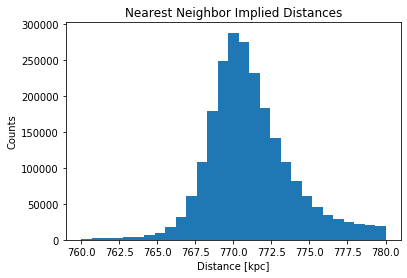

In [32]:
plt.hist(distAbsMean,bins=np.linspace(760,780,30))
plt.xlabel('Distance [kpc]')
plt.ylabel('Counts')
plt.title('Nearest Neighbor Implied Distances')
plt.show()

## Let's visualize the spread of neighbor radii

In [33]:
neighborRadiiStd = [np.std(neighborRadii[i]) for i in range(len(neighborRadii))]

In [34]:
#neighborRadiiError = [neighborRadiiStd[i]/neighborRadiiMean[i] * 100 for i in range(len(neighborRadiiStd))]

In [35]:
#plt.hist(neighborRadiiError,bins=np.linspace(0,10,15))
#plt.title('Percent STD of Nearest Neighbor Radii')
#plt.xlabel('Percent error (std/mean for each neighbor set)')
#plt.ylabel('Count')
#plt.show()

In [36]:
#Fit two gaussians to the data (https://stackoverflow.com/questions/35990467/fit-two-gaussians-to-a-histogram-from-one-set-of-data-python)
def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

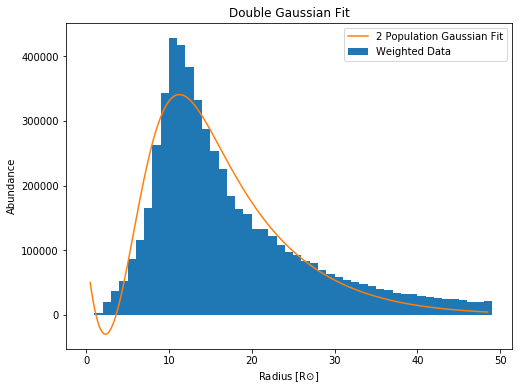

In [37]:
plt.figure(figsize=(8,6))
xmin = 0
xmax = 49
nbins = 50
#y,x,_ = plt.hist(meanSourceRadii,bins=np.linspace(xmin,xmax,nbins),label='data')
y,x,_ = plt.hist(weightedRadiiFinal,bins=np.linspace(xmin,xmax,nbins),label='Weighted Data')
x = x[0:-1] #Fix bin edge number problem
x = x + (xmax-xmin)/(2*float(nbins)) #Center the bins
xnew = np.linspace(min(x),max(x), 1000)

expected = (3, 2, 200000, 13, 2, 50000) #Approximating mean, std, amplitude

params, cov = curve_fit(bimodal,x,y,expected)
sigma = np.sqrt(np.diag(cov))
plt.plot(xnew,bimodal(xnew,*params),label='2 Population Gaussian Fit')
plt.xlabel('Radius [R$\odot$]')
plt.ylabel('Abundance')
plt.title('Double Gaussian Fit')
plt.legend()

plt.savefig('GaussianFit.png')
plt.show()

In [38]:
#The parameters for each population
print('Mean: \n', params[0], params[3])
print('std: \n', params[1], params[4])
print('amplitude: \n', params[2], params[5])

Mean: 
 0.08539582559849293 -74.43647808766859
std: 
 5.051227288863818 29.069489687727813
amplitude: 
 -1189072.1825711317 34237953.26872616


## Can basically ignore everything below here for now!

In [37]:
#Over 97% of all stars have radius of x[23] or less we can just use these bins
#print(sum(y[23:])/sum(y))

In [ ]:
#x[0:23]

In [ ]:
#y[0:23]

In [ ]:
#Visual of nearest neighbors at work
#plt.figure(figsize=(10,8))
#plt.scatter(x,y,color='k')
#plt.scatter(x[resultIdx],y[resultIdx],color='r')
#plt.scatter(testpoints[:,0],testpoints[:,1],color='b')
#plt.xlabel('F475W-F814W')
#plt.ylabel('F814W')
#plt.gca().invert_yaxis()

#plt.show()

In [ ]:
#x2 = np.subtract(F475WCulled,F814WCulled)
#y2 = F814WCulled
#nbins=300
#k2 = kde.gaussian_kde([x2,y2])
#xi2, yi2 = np.mgrid[x2.min():x2.max():nbins*1j, y2.min():y2.max():nbins*1j]
#zi2 = k2(np.vstack([xi2.flatten(), yi2.flatten()]))

In [ ]:
#plt.figure(figsize=(8,6))

#plt.scatter(x,y,color='k')
#plt.scatter(x2,y2,color='r')
#plt.gca().invert_xaxis()


#plt.pcolormesh(xi2, yi2, zi2.reshape(xi2.shape),cmap=plt.get_cmap('viridis'), alpha=0.4)
#plt.colorbar()    

#plt.gca().invert_yaxis()
#plt.xlabel('F475W-F814W')
#plt.ylabel('F814W')
#plt.title('PHAT Color-Mag')
#plt.show()

In [ ]:
#print('photometric system: ', isocmd.photo_sys)
#print('hdr list: ', isocmd.hdr_list)

In [ ]:
#age_ind = isocmd.age_index(6.5)
#F475W = isocmd.isocmds[age_ind]['ACS_WFC_F475W']
#F814W = isocmd.isocmds[age_ind]['ACS_WFC_F814W']

#plt.scatter(F475W-F814W, F814W)
#plt.xlabel('F475W-F814W')
#plt.ylabel('F814W')
#plt.gca().invert_yaxis()

In [ ]:
#Save data:
#np.save('F475W_data',F475W)
#np.save('F814W_data',F814W)
#np.save('bolLum_data',bolLum) 
#np.save('tEff_data',tEff)

In [ ]:
#F475WCulled = np.load('F475WCulled_data.npy')
#F814WCulled = np.load('F814WCulled_data.npy')
#F475W_GST = np.load('F475W_GST_data.npy')
#F814W_GST = np.load('F814W_GST_data.npy')